Principal Component Analysis

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data.
Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).

We begin with the standard imports:

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:

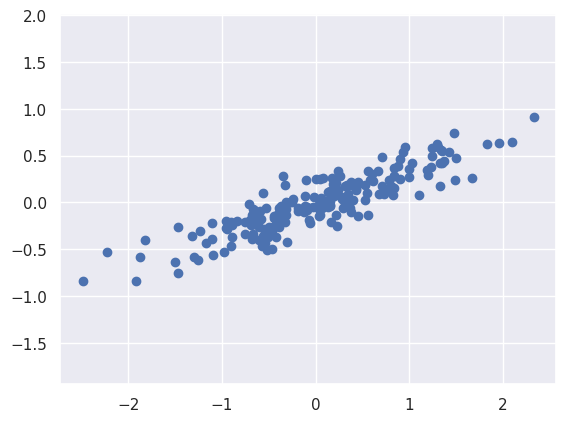

In [33]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables.
This is reminiscent of the linear regression data we explored in In Depth: Linear, but the problem setting here is slightly different: rather than attempting to *predict* the y values from the x values, the unsupervised learning problem attempts to learn about the *relationship* between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [35]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [36]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

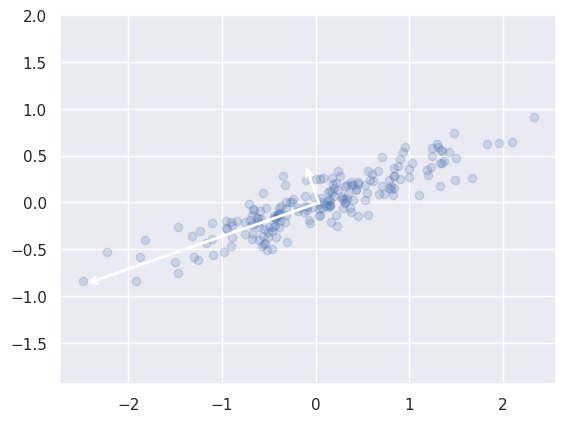

In [37]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the *principal axes* of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [38]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

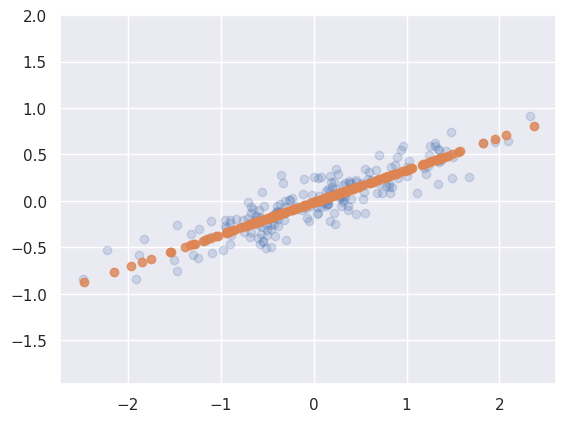

In [39]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.

### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.

We start by loading the data:

In [40]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.

In [41]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:

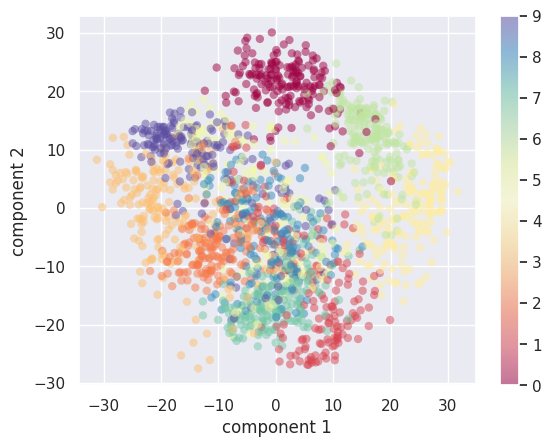

In [42]:
import matplotlib as mpl
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=mpl.colormaps['Spectral'])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:

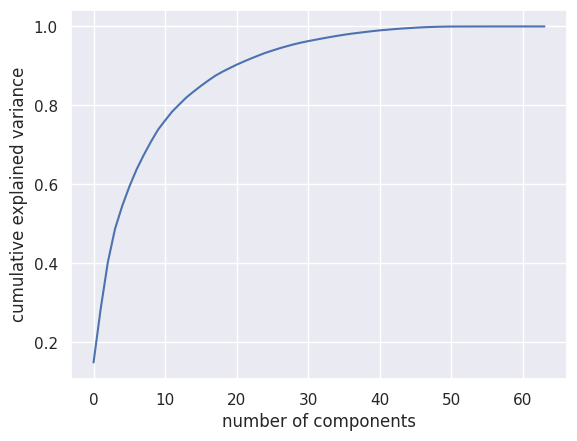

In [43]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.

## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free data:

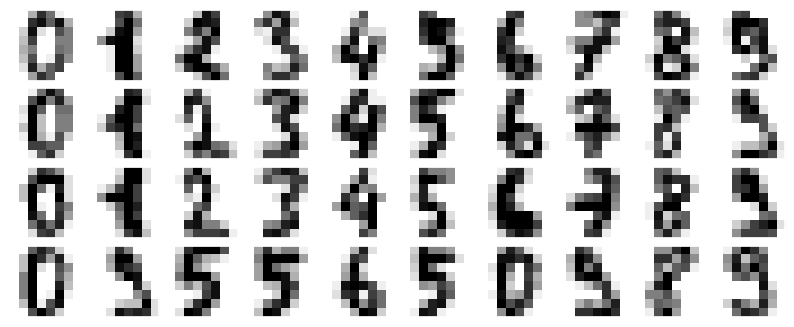

In [44]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now lets add some random noise to create a noisy dataset, and re-plot it:

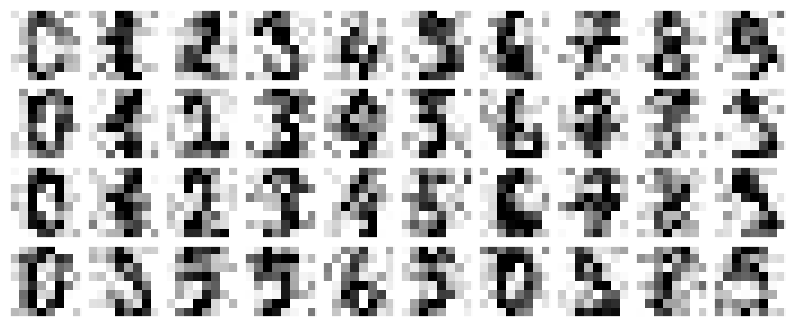

In [45]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels.
Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

In [46]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

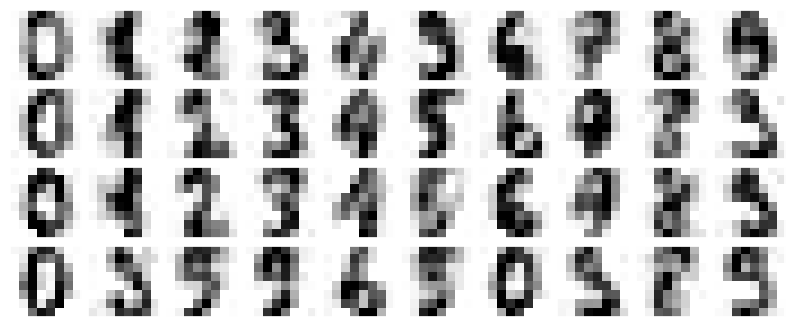

In [47]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

## Example: Eigenfaces

Earlier we explored an example of using a PCA projection as a feature selector for facial recognition with a support vector machine Support Vector Machines.
Recall that we were using the Labeled Faces in the Wild dataset made available through Scikit-Learn:

In [48]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's take a look at the principal axes that span this dataset.

We will take a look at the first 150 components:

In [49]:
from sklearn.decomposition import PCA
pca = PCA(150)
pca.fit(faces.data)

PCA(n_components=150)

In this case, it can be interesting to visualize the images associated with the first several principal components.

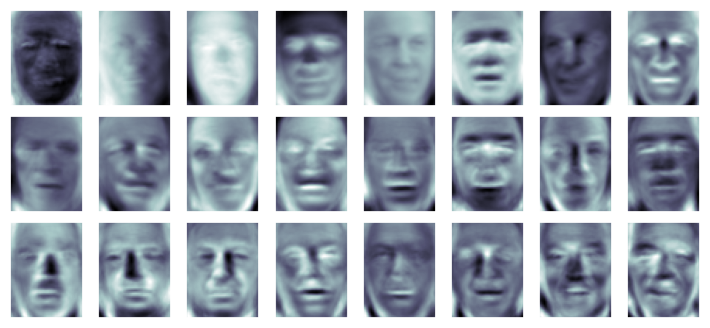

In [50]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

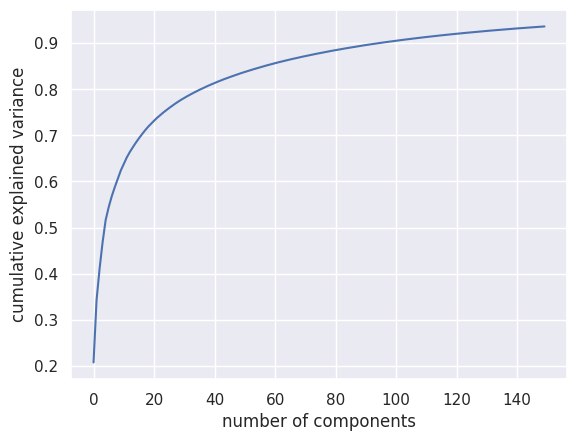

In [51]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 150 components account for just over 90% of the variance.

To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [52]:
# Compute the components and projected faces
pca = PCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

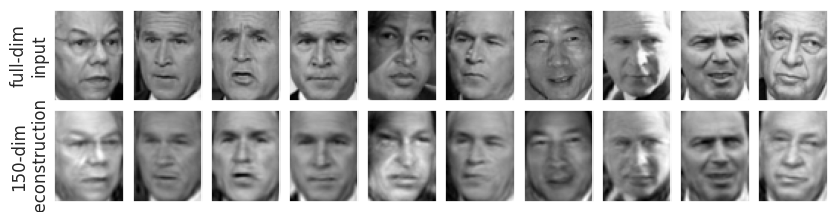

In [53]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.